In [1]:
from brian2 import *
from matplotlib import pyplot as plt
import numpy as np
from src.nb_helpers import *


%matplotlib inline
seed(12345)

In [2]:
start_scope()

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 10*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step

N_sst = 2 # Number of SST neurons (inhibitory)
N_pv = 2  # Number of PV neurons (inhibitory)
N_cc = 2  # Number of CC neurons (excitatory)
N_cs = 2  # Number of CS neurons (excitatory)

### Neuron parameters
tau_S   = 16*ms  # 
tau_D   =  7*ms  #
tau_SST = 20*ms  #
tau_PV  = 10*ms  #
tau_E   =  5*ms  # Excitatory synaptic time constant
tau_I   = 10*ms  # Inhibitory synaptic time constant

C_S   = 370*pF
C_D   = 170*pF
C_SST = 100*pF
C_PV  = 100*pF

E_l  = -70*mV   # leak reversal potential
E_e  =   0*mV   # Excitatory synaptic reversal potential
E_i  = -80*mV   # Inhibitory synaptic reversal potential

V_t  = -50*mV   # spiking threashold
V_r  = E_l      # reset potential

c_d = 2600 * pA  # back-propagates somatic spikes to to the dendrites
g_s = 1300 * pA  # propagates dendritic regenerative activity to soma
g_d = 1200 * pA  # propagates dendritic regenerative activity to denderites

### Sigmoid function params
E_d = -38*mV  # position control of threshold
D_d =   6*mV  # sharpness control of threshold 

### Synapse parameters
w_e = 0.05*nS  # Excitatory synaptic conductance
w_i = 1.0*nS   # Inhibitory synaptic conductance

################################################################################

In [3]:
TIME_FRAME = 0.1

index_to_ntype_dict = {
    0: 'CS',
    1: 'CC',
    2: 'SST',
    3: 'PV'
}

### Base external input
g = 50*nS
l = 10*Hz

def compute_scaling_factor(i):
    return 1 + np.power(1/2, i)

def compute_equilibrium_time(spike_mons):
    equilibrium_times = []
    for idx, spike_mon in enumerate(spike_mons):
        t, firing_rate = compute_equilibrium_for_neuron_type(spike_mon, TIME_FRAME)
        equilibrium_times.append(t)

    equilibrium_t = max(equilibrium_times)*second
    if equilibrium_t < duration:
        print(f"Equilibrium for all neurons start at: {equilibrium_t}")
    else: 
        print(f"WARNING: Equilibrium was not found during the duration of the simulation")
    
    return equilibrium_t

In [4]:
eqs_sst_inh = '''
    dv/dt = ((E_l-v)/tau_SST + I/C_SST) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens
    
    I = g_e*(E_e - v) + g_i*(E_i - v) : amp
'''

eqs_pv_inh = '''
    dv/dt = ((E_l-v)/tau_PV + I/C_PV) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = g_e*(E_e - v) + g_i*(E_i - v) : amp
'''

eqs_exc = '''
    dv_s/dt = ((E_l-v_s)/tau_S + (g_s*(1/(1+exp(-(v_d-E_d)/D_d))) + I_s)/C_S) : volt (unless refractory)

    dg_es/dt = -g_es/tau_E : siemens
    dg_is/dt = -g_is/tau_I : siemens

    I_s = g_es*(E_e - v_s) + g_is*(E_i - v_s) : amp

    dv_d/dt = ((E_l-v_d)/tau_D + (g_d*(1/(1+exp(-(v_d-E_d)/D_d))) + c_d*K + I_d)/C_D) : volt

    dg_ed/dt = -g_ed/tau_E : siemens
    dg_id/dt = -g_id/tau_I : siemens

    I_d = g_ed*(E_e - v_d) + g_id*(E_i - v_d) : amp
    K : 1
'''

In [5]:
# SST Neurons
sst_neurons = NeuronGroup(N_sst, model=eqs_sst_inh, threshold='v > V_t',
                              reset='v = E_l', refractory=8.3 * ms, method='euler')
sst_neurons.v = 'E_l + rand()*(V_t-E_l)'
sst_neurons.g_e = 'rand()*w_e'
sst_neurons.g_i = 'rand()*w_i'

# PV Neurons
pv_neurons = NeuronGroup(N_pv, model=eqs_pv_inh, threshold='v > V_t',
                             reset='v = E_l', refractory=8.3 * ms, method='euler')
pv_neurons.v = 'E_l + rand()*(V_t-E_l)'
pv_neurons.g_e = 'rand()*w_e'
pv_neurons.g_i = 'rand()*w_i'

# CS Neurons
cs_neurons = NeuronGroup(N_cs, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cs_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cs_neurons.v_d = -70 * mV
cs_neurons.g_es = cs_neurons.g_ed = 'rand()*w_e'
cs_neurons.g_is = cs_neurons.g_id = 'rand()*w_i'

# CC Neurons
cc_neurons = NeuronGroup(N_cc, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cc_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cc_neurons.v_d = -70 * mV
cc_neurons.g_es = cc_neurons.g_ed = 'rand()*w_e'
cc_neurons.g_is = cc_neurons.g_id = 'rand()*w_i'

In [6]:
# CS_CS 0, CS_SST 1, CS_PV 2, SST_CS 3, PV_CS 4, CC_CC 5, CC_SST 6, CC_PV 7, SST_CC 8, PV_CC 9, CC_CS 10, SST_PV 11, SST_SST 12, PV_PV 13, PV_SST 14, 
# conn_probs = [0.16, 0.23, 0.18, 0.52, 0.43, 0.06, 0.26, 0.22, 0.13, 0.38, 0.09, 0.29, 0.1, 0.5, 0.14]
conn_probs = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# SST <=> PV
conn_SST_PV = Synapses(sst_neurons, pv_neurons, on_pre='g_i+=w_i', name='SST_PV') # inhibitory
conn_SST_PV.connect(p=conn_probs[11])
conn_PV_SST = Synapses(pv_neurons, sst_neurons, on_pre='g_i+=w_i', name='PV_SST') # inhibitory
conn_PV_SST.connect(p=conn_probs[14])

# PV <=> PYR soma
## target CS soma
conn_PV_CSsoma = Synapses(pv_neurons, cs_neurons, on_pre='g_is+=w_i', name='PV_CSsoma') # inhibitory
conn_PV_CSsoma.connect(p=conn_probs[4])
conn_CSsoma_PV = Synapses(cs_neurons, pv_neurons, on_pre='g_e+=w_e', name='CSsoma_PV') # excitatory
conn_CSsoma_PV.connect(p=conn_probs[2])

## target CC soma
conn_PV_CCsoma = Synapses(pv_neurons, cc_neurons, on_pre='g_is+=w_i', name='PV_CCsoma') # inhibitory 
conn_PV_CCsoma.connect(p=conn_probs[9])
conn_CCsoma_PV = Synapses(cc_neurons, pv_neurons, on_pre='g_e+=w_e', name='CCsoma_PV') # excitatory
conn_CCsoma_PV.connect(p=conn_probs[7])

# SST <=> PYR soma
## target CS soma
conn_SST_CSsoma = Synapses(sst_neurons, cs_neurons, on_pre='g_is+=w_i', name='SST_CSsoma') # inhibitory (optional connection)
conn_SST_CSsoma.connect(p=conn_probs[3])
conn_CSsoma_SST = Synapses(cs_neurons, sst_neurons, on_pre='g_e+=w_e', name='CSsoma_SST') # excitatory
conn_CSsoma_SST.connect(p=conn_probs[1])

## taget CC soma
conn_SST_CCsoma = Synapses(sst_neurons, cc_neurons, on_pre='g_is+=w_i', name='SST_CCsoma') # inhibitory (optional connection)
conn_SST_CCsoma.connect(p=conn_probs[8])
conn_CCsoma_SST = Synapses(cc_neurons, sst_neurons, on_pre='g_e+=w_e', name='CCsoma_SST') # excitatory
conn_CCsoma_SST.connect(p=conn_probs[6])

# CC => CS 
## target CS soma
conn_SST_CCdendrite = Synapses(cc_neurons, cs_neurons, on_pre='g_es+=w_e', name='CC_CSsoma') # excitatory
conn_SST_CCdendrite.connect(p=conn_probs[10])

# self connections
conn_CSsoma_CSsoma = Synapses(cs_neurons, cs_neurons, on_pre='g_es+=w_e', name='CSsoma_CSsoma')  # excitatory
conn_CSsoma_CSsoma.connect(p=conn_probs[0])
backprop_CS = Synapses(cs_neurons, cs_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CS')
backprop_CS.connect(condition='i==j')  # Connect all CS neurons to themselves

conn_CCsoma_CCsoma = Synapses(cc_neurons, cc_neurons, on_pre='g_es+=w_e', name='CCsoma_CCsoma')  # excitatory
conn_CCsoma_CCsoma.connect(p=conn_probs[5])
backprop_CC = Synapses(cc_neurons, cc_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CC')
backprop_CC.connect(condition='i==j')  # Connect all CC neurons to themselves

conn_SST_SST = Synapses(sst_neurons, sst_neurons, on_pre='g_i+=w_i', name='SST_SST')  # inhibitory
conn_SST_SST.connect(p=conn_probs[12])

conn_PV_PV = Synapses(pv_neurons, pv_neurons, on_pre='g_i+=w_i', name='PV_PV')  # inhibitory
conn_PV_PV.connect(p=conn_probs[13])


# SST => PYR dendrite
## target CS dendrite
conn_SST_CSdendrite = Synapses(sst_neurons, cs_neurons, on_pre='g_id+=w_i', name='SST_CSdendrite') # inhibitory
conn_SST_CSdendrite.connect(p=conn_probs[3]) # not sure about this here

## target CC dendrite
conn_SST_CCdendrite = Synapses(sst_neurons, cc_neurons, on_pre='g_id+=w_i', name='SST_CCdendrite') # inhibitory
conn_SST_CCdendrite.connect(p=conn_probs[8]) # not sure about this here

# Record spikes of different neuron groups
spike_mon_sst = SpikeMonitor(sst_neurons)
spike_mon_pv = SpikeMonitor(pv_neurons)
spike_mon_cs = SpikeMonitor(cs_neurons)
spike_mon_cc = SpikeMonitor(cc_neurons)

spike_monitors = [spike_mon_sst, spike_mon_pv, spike_mon_cs, spike_mon_cc]

net = Network(collect())

# Snapshot the state
net.store('fresh')

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


In [7]:
# ##############################################################################
# # Simulation run for varying external input
# ##############################################################################
print("Simulation for varying external input scaling factor.\n")

defaultclock.dt = sim_dt

for i in range(6):
    net.restore('fresh')  # Restore the initial state
    
    # DEFINE custom inputs
    
    l_M = 1
    g_M = compute_scaling_factor(i)
    print(f"Inputs [{g}, {g*g_M}] Factor={g_M}")
    
    I_ext_sst = [0*nS for i in range(N_sst)]
    I_ext_pv = [0*nS for i in range(N_pv)]
    I_ext_cs = I_ext_cc = [g, g*g_M]
    lambda_cs = lambda_cc = [l, l*l_M]
    
    # Poisson input to CS neurons
    cs_neurons_p1 = PoissonInput(cs_neurons[0], 'g_es', N=1, rate=lambda_cs[0], weight=I_ext_cs[0])
    cs_neurons_p2 = PoissonInput(cs_neurons[1], 'g_es', N=1, rate=lambda_cs[1], weight=I_ext_cs[1])
    
    # Poisson input to CC neurons
    cc_neurons_p1 = PoissonInput(cc_neurons[0], 'g_es', N=1, rate=lambda_cc[0], weight=I_ext_cc[0])
    cc_neurons_p2 = PoissonInput(cc_neurons[1], 'g_es', N=1, rate=lambda_cc[1], weight=I_ext_cc[1])

    inputs = [cs_neurons_p1, cs_neurons_p2, cc_neurons_p1, cc_neurons_p2]
    net.add(inputs) # Add custom inputs
    
    net.run(duration, report='text') # store the results
    
    from_t = compute_equilibrium_time(spike_monitors)
    to_t = duration

    # Compute firing rate for each neuron group
    firing_rates_cs = compute_firing_rate_for_neuron_type(spike_mon_cs, from_t, to_t)
    firing_rates_cc = compute_firing_rate_for_neuron_type(spike_mon_cc, from_t, to_t)
    firing_rates_sst = compute_firing_rate_for_neuron_type(spike_mon_sst, from_t, to_t)
    firing_rates_pv = compute_firing_rate_for_neuron_type(spike_mon_pv, from_t, to_t)

    print(f'Avg firing rate for CS neurons: {np.mean(firing_rates_cs) * Hz}')
    print(f'Avg firing rate for CC neurons: {np.mean(firing_rates_cc) * Hz}')
    print(f'Avg firing rate for SST neurons: {np.mean(firing_rates_sst) * Hz}')
    print(f'Avg firing rate for PV neurons: {np.mean(firing_rates_pv) * Hz}')
    
    net.remove(inputs) # Remove custom inputs
    
    print("===============================================================================\n")
    
    

Simulation for varying external input scaling factor.

Inputs [50. nS, 100. nS] Factor=2.0
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 8s
Equilibrium for all neurons start at: 4.3 s
Avg firing rate for CS neurons: 9.73684211 Hz
Avg firing rate for CC neurons: 10.1754386 Hz
Avg firing rate for SST neurons: 0. Hz
Avg firing rate for PV neurons: 0. Hz

Inputs [50. nS, 75. nS] Factor=1.5
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 8s
Equilibrium for all neurons start at: 3.5 s
Avg firing rate for CS neurons: 9.53846154 Hz
Avg firing rate for CC neurons: 9.15384615 Hz
Avg firing rate for SST neurons: 0. Hz
Avg firing rate for PV neurons: 0. Hz

Inputs [50. nS, 62.5 nS] Factor=1.25
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 8s
Equilibrium for all neurons start at: 0.9 s
Avg firing rate for CS neurons: 8.68131868 Hz
Avg firing rate for CC neurons: 9.06593407 Hz
Avg firing rate for SST 

In [8]:
# ##############################################################################
# # Simulation run for varying poisson rate
# ##############################################################################
      
defaultclock.dt = sim_dt

print(f"Simulation for varying external poisson rate factor.\n")
for i in range(6):
    net.restore('fresh')  # Restore the initial state

    # DEFINE custom inputs
    
    l_M = compute_scaling_factor(i)
    g_M = 1
    print(f"Poisson rates [{l}, {l*l_M}] Factor={l_M}")
    
    I_ext_sst = [0*nS for i in range(N_sst)]
    I_ext_pv = [0*nS for i in range(N_pv)]
    I_ext_cs = I_ext_cc = [g, g*g_M]
    lambda_cs = lambda_cc = [l, l*l_M]
    
    # Poisson input to CS neurons
    cs_neurons_p1 = PoissonInput(cs_neurons[0], 'g_es', N=1, rate=lambda_cs[0], weight=I_ext_cs[0])
    cs_neurons_p2 = PoissonInput(cs_neurons[1], 'g_es', N=1, rate=lambda_cs[1], weight=I_ext_cs[1])
    
    # Poisson input to CC neurons
    cc_neurons_p1 = PoissonInput(cc_neurons[0], 'g_es', N=1, rate=lambda_cc[0], weight=I_ext_cc[0])
    cc_neurons_p2 = PoissonInput(cc_neurons[1], 'g_es', N=1, rate=lambda_cc[1], weight=I_ext_cc[1])

    inputs = [cs_neurons_p1, cs_neurons_p2, cc_neurons_p1, cc_neurons_p2]
    net.add(inputs) # Add custom inputs
    
    net.run(duration, report='text') # store the results
    
    from_t = compute_equilibrium_time(spike_monitors)
    to_t = duration

    # Compute firing rate for each neuron group
    firing_rates_cs = compute_firing_rate_for_neuron_type(spike_mon_cs, from_t, to_t)
    firing_rates_cc = compute_firing_rate_for_neuron_type(spike_mon_cc, from_t, to_t)
    firing_rates_sst = compute_firing_rate_for_neuron_type(spike_mon_sst, from_t, to_t)
    firing_rates_pv = compute_firing_rate_for_neuron_type(spike_mon_pv, from_t, to_t)

    print(f'Avg firing rate for CS neurons: {np.mean(firing_rates_cs) * Hz}')
    print(f'Avg firing rate for CC neurons: {np.mean(firing_rates_cc) * Hz}')
    print(f'Avg firing rate for SST neurons: {np.mean(firing_rates_sst) * Hz}')
    print(f'Avg firing rate for PV neurons: {np.mean(firing_rates_pv) * Hz}')
    
    net.remove(inputs) # Remove custom inputs
    
    print("===============================================================================\n")
    
    

Simulation for varying external poisson rate factor.

Poisson rates [10. Hz, 20. Hz] Factor=2.0
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 8s
Equilibrium for all neurons start at: 4.3 s
Avg firing rate for CS neurons: 13.59649123 Hz
Avg firing rate for CC neurons: 13.33333333 Hz
Avg firing rate for SST neurons: 0. Hz
Avg firing rate for PV neurons: 0. Hz

Poisson rates [10. Hz, 15. Hz] Factor=1.5
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 8s
Equilibrium for all neurons start at: 0.8 s
Avg firing rate for CS neurons: 11.68478261 Hz
Avg firing rate for CC neurons: 11.57608696 Hz
Avg firing rate for SST neurons: 0. Hz
Avg firing rate for PV neurons: 0. Hz

Poisson rates [10. Hz, 12.5 Hz] Factor=1.25
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 8s
Equilibrium for all neurons start at: 6.3 s
Avg firing rate for CS neurons: 9.72972973 Hz
Avg firing rate for CC neurons: 11.62162162 Hz


In [9]:
# neuron-specific input
values = (linspace(0*mV, 20*mV, 100)[:, None] *
          linspace(0, 1, 5))
I = TimedArray(values, dt=10*ms)

In [10]:
I(0*second, 0)

0. * volt

In [11]:
linspace(0*mV, 20*mV, 100)[:, None] * linspace(0, 1, 5)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.05050505,  0.1010101 ,  0.15151515,  0.2020202 ],
       [ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ],
       [ 0.        ,  0.15151515,  0.3030303 ,  0.45454545,  0.60606061],
       [ 0.        ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.80808081],
       [ 0.        ,  0.25252525,  0.50505051,  0.75757576,  1.01010101],
       [ 0.        ,  0.3030303 ,  0.60606061,  0.90909091,  1.21212121],
       [ 0.        ,  0.35353535,  0.70707071,  1.06060606,  1.41414141],
       [ 0.        ,  0.4040404 ,  0.80808081,  1.21212121,  1.61616162],
       [ 0.        ,  0.45454545,  0.90909091,  1.36363636,  1.81818182],
       [ 0.        ,  0.50505051,  1.01010101,  1.51515152,  2.02020202],
       [ 0.        ,  0.55555556,  1.11111111,  1.66666667,  2.22222222],
       [ 0.        ,  0.60606061,  1.21212121,  1.81818182,  2.42424242],
       [ 0.        ,  0.65656566,  1.3

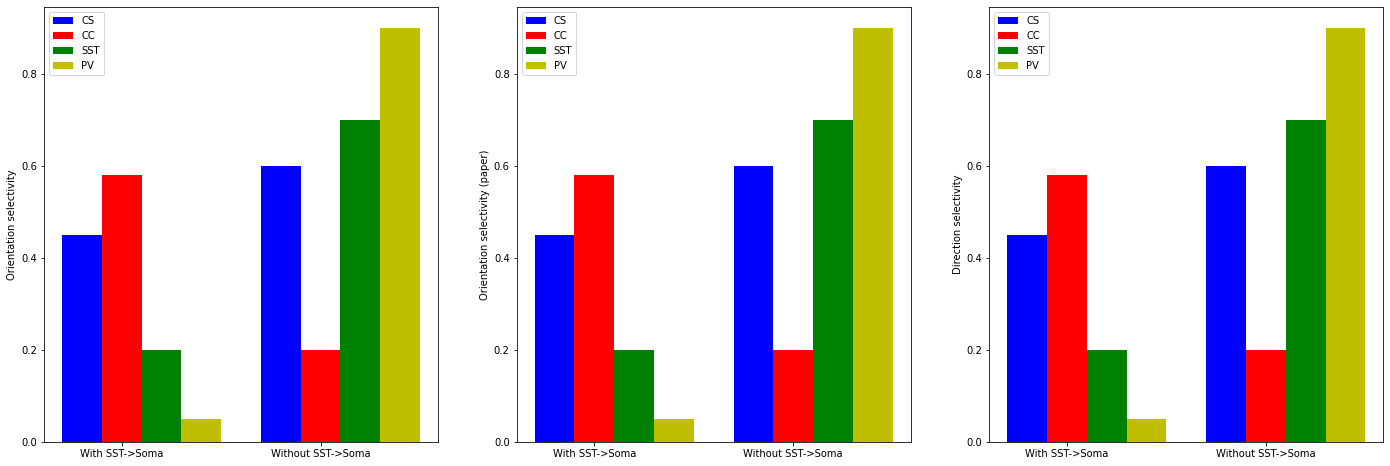

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
bar_width = 0.4
x = np.arange(2)/2
labels = ['With SST->Soma', 'Without SST->Soma']

# plot orientation selectivity
axs[0].bar(x, [0.45, 0.6], bar_width/4, label="CS", color='b')
axs[0].bar(x + bar_width/4, [0.58, 0.2], bar_width/4, label="CC", color='r')
axs[0].bar(x + bar_width/2, [0.2, 0.7], bar_width/4, label="SST", color='g')
axs[0].bar(x + bar_width*3/4, [0.05, 0.9], bar_width/4, label="PV", color='y')
axs[0].set_ylabel('Orientation selectivity')
axs[0].set_xticks(x+bar_width/4)
axs[0].set_xticklabels(labels)
axs[0].legend(loc='best')

# plot orientation selectivity (paper)
axs[1].bar(x, [0.45, 0.6], bar_width/4, label="CS", color='b')
axs[1].bar(x + bar_width/4, [0.58, 0.2], bar_width/4, label="CC", color='r')
axs[1].bar(x + bar_width/2, [0.2, 0.7], bar_width/4, label="SST", color='g')
axs[1].bar(x + bar_width*3/4, [0.05, 0.9], bar_width/4, label="PV", color='y')
axs[1].set_ylabel('Orientation selectivity (paper)')
axs[1].set_xticks(x+bar_width/4)
axs[1].set_xticklabels(labels)
axs[1].legend(loc='best')

# plot direction selectivity
axs[2].bar(x, [0.45, 0.6], bar_width/4, label="CS", color='b')
axs[2].bar(x + bar_width/4, [0.58, 0.2], bar_width/4, label="CC", color='r')
axs[2].bar(x + bar_width/2, [0.2, 0.7], bar_width/4, label="SST", color='g')
axs[2].bar(x + bar_width*3/4, [0.05, 0.9], bar_width/4, label="PV", color='y')
axs[2].set_ylabel('Direction selectivity')
axs[2].set_xticks(x+bar_width/4)
axs[2].set_xticklabels(labels)
axs[2].legend(loc='best')